In [11]:
# Import necessary modules, librarys, and resources
import pyexpat
import pprint

!pip install --user numpy==1.22.3
!pip install --user nba_api

pp = pprint.PrettyPrinter(indent=4)
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from PIL import Image

# Import from nba_api module
from nba_api.stats.endpoints import commonplayerinfo, shotchartdetail, commonteamroster
from nba_api.stats.static import players, teams

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Verdana']

# Load the basketball court image and colourmap that will be used for all plots
img = np.asarray(Image.open("E:\OneDrive - University of Waterloo\Spring 2023\GEOG 381\Assignment 3\MyProject3\TOR_Court_2021.tif"))
cmap = plt.get_cmap('RdYlGn')

In [12]:
def print_dict(dict):
    for key in dict.keys():
        print(key.capitalize().replace("_", " "), ":", dict[key])
        

def get_player_shot_chart(player_id, season, season_type):
    shot_chart = shotchartdetail.ShotChartDetail(
        player_id=player_id,
        season_nullable=season,
        season_type_all_star=season_type,
        team_id=0,
        context_measure_simple='FGA'
    )
    return shot_chart
    
    
def get_team_schart(team_id, season, season_type):
    roster = commonteamroster.CommonTeamRoster(team_id, season=season)
    players = roster.get_dict()['resultSets'][0]
    
    roster_shot_charts = {}
    longest_name = 0
    
    for player_data in players['rowSet']:
        name = player_data[3]
        longest_name = len(name) if longest_name < len(name) else longest_name
        player_id = player_data[-2]
        
        try:
            roster_shot_charts[name] = get_player_shot_chart(player_id, season, season_type)
        except:
            pass
    
    print(players['headers'][3].ljust(longest_name + 5), players['headers'][-2].rjust(10))
    for player_name in roster_shot_charts.keys():
        print(player_name.ljust(longest_name + 5), str(player_id).rjust(10))
    
    return roster_shot_charts

In [13]:
def get_player_shot_df(team_shot_charts, playername):
    return team_shot_charts[playername].shot_chart_detail.get_data_frame()


def show_roster(team_shot_charts):
    for playername in team_shot_charts.keys():
        shot_df = get_player_shot_df(team_shot_charts, playername)

        
def gen_team_shot_df(team_shot_charts):
    return pd.concat([i.shot_chart_detail.get_data_frame() for i in team_shot_charts.values()])
    

def plot_shots_from_df(shot_df, split=False):
    MADE = shot_df[shot_df['SHOT_MADE_FLAG']==1]
    MISSED = shot_df[shot_df['SHOT_MADE_FLAG']==0]
    if split:
        plt.plot(MADE.LOC_X, MADE.LOC_Y,'o',color='green')
        plt.plot(MISSED.LOC_X, MISSED.LOC_Y,'x',color='red')
    else:
        plt.plot(shot_df.LOC_X, shot_df.LOC_Y,'o',color='black')
        

def plot_df_hex(shot_df, name, season, season_type):
    fig = plt.figure(figsize=(14,11))
    
    hexplot = plt.hexbin(shot_df["LOC_X"], shot_df["LOC_Y"], C=shot_df['SHOT_MADE_FLAG'], gridsize=35,
                         vmin = 0.0, vmax = 0.7, cmap=cmap)
    
    plt.colorbar(label="Proportion of shots made (Out of 1.0)")
    
    plt.xlim(300,-300)
    plt.ylim(-100,500)

    court_img()
    plt.title(name + " " + season + " " + season_type + " Shot Efficiency")
    plt.text(250, -75,'Data Source: stats.nba.com'
             '\nAuthor: Jamse Wang',
             fontsize=12)
    # Show the plot.
    plt.show()
    
    
def plot_player(team_scharts, player_name, season, season_type):
    shot_df = get_player_shot_df(team_scharts, player_name)
    plot_df_hex(shot_df, player_name, season, season_type)


def plot_team(team_scharts, team_name, season, season_type):    
    shot_df = gen_team_shot_df(team_scharts)
    plot_df_hex(shot_df, team_name, season, season_type)


def plot_delta(team_scharts, player_name, team_name, season, season_type):
    figure = plt.figure(figsize=(14, 11))
    frames = []
    for i in team_scharts.keys():
        if i != player_name:
            frames.append(team_scharts[i].shot_chart_detail.get_data_frame())
            
    team_df = pd.concat(frames)
    player_df = get_player_shot_df(team_scharts, player_name)
    
    team_hex = plt.hexbin(team_df["LOC_X"], team_df["LOC_Y"], C=team_df['SHOT_MADE_FLAG'], gridsize=35,
                         vmin = 0.0, vmax = 0.7, cmap=cmap)
    player_hex = plt.hexbin(player_df["LOC_X"], player_df["LOC_Y"], C=player_df['SHOT_MADE_FLAG'], gridsize=35,
                         vmin = 0.0, vmax = 0.7, cmap=cmap)
    plt.clf()
    delta_a, delta_x, delta_y = [], [], []
    
    for i in range(len(player_hex.get_array())):
        delta_a.append(player_hex.get_array()[i] - team_hex.get_array()[i])
        delta_x.append(player_hex.get_offsets()[i][0])
        delta_y.append(player_hex.get_offsets()[i][1])
        
    delta_hex = plt.hexbin(delta_x, delta_y, delta_a, gridsize=35, vmin=-0.7, vmax=0.7, cmap=cmap)
    
    plt.colorbar(label="Difference in Proportion of shots made")
    
    plt.xlim(300,-300)
    plt.ylim(-100,500)

    court_img()
    plt.title(player_name + " " + season + " " + season_type + " Shot Efficiency Compared to Team")
    plt.text(250, -75,'Data Source: stats.nba.com'
             '\nAuthor: Jamse Wang',
             fontsize=12)
    # Show the plot.
    plt.show()

def court_img():
    img = np.asarray(Image.open("E:\OneDrive - University of Waterloo\Spring 2023\GEOG 381\Assignment 3\MyProject3\TOR_Court_2021.tif"))
    plt.imshow(img, origin='upper', extent=[250, -250, -47.5, 470 - 47.5])

In [14]:
def input_loop(team_name, team_num, season, season_type):
    team_schart_dict = get_team_schart(team_num, season, season_type)
    plot_team(team_schart_dict, team_name, season, season_type)

    show_roster(team_schart_dict)

    while True:
        print("Which player would you like to plot? type name without spelling mistakes, 000 to go back to team selection")
        in_name = input()
        if in_name == "000":
            return
        else:
            plot_player(team_schart_dict, in_name, season, season_type)
            plot_delta(team_schart_dict, in_name, team_name, season, season_type)
            

def main__():
    
    while True:
        print("Team List")
        for team in teams.get_teams():
            print("{:<40}{:>14}".format(team['full_name'], team['id']))

        team_name = input("\nTeam Name (000 to exit): ")
        if team_name == "000":
            break
        season = input("Season (i.e 2017-18): ")
        season_type = input("Season Type (Regular Season or Playoffs): ")
        
        print("\nLoading")
        team_num = teams.find_teams_by_full_name(team_name)[0]['id']
        input_loop(team_name, team_num, season, season_type)

Team List
Atlanta Hawks                               1610612737
Boston Celtics                              1610612738
Cleveland Cavaliers                         1610612739
New Orleans Pelicans                        1610612740
Chicago Bulls                               1610612741
Dallas Mavericks                            1610612742
Denver Nuggets                              1610612743
Golden State Warriors                       1610612744
Houston Rockets                             1610612745
Los Angeles Clippers                        1610612746
Los Angeles Lakers                          1610612747
Miami Heat                                  1610612748
Milwaukee Bucks                             1610612749
Minnesota Timberwolves                      1610612750
Brooklyn Nets                               1610612751
New York Knicks                             1610612752
Orlando Magic                               1610612753
Indiana Pacers                              1610612754


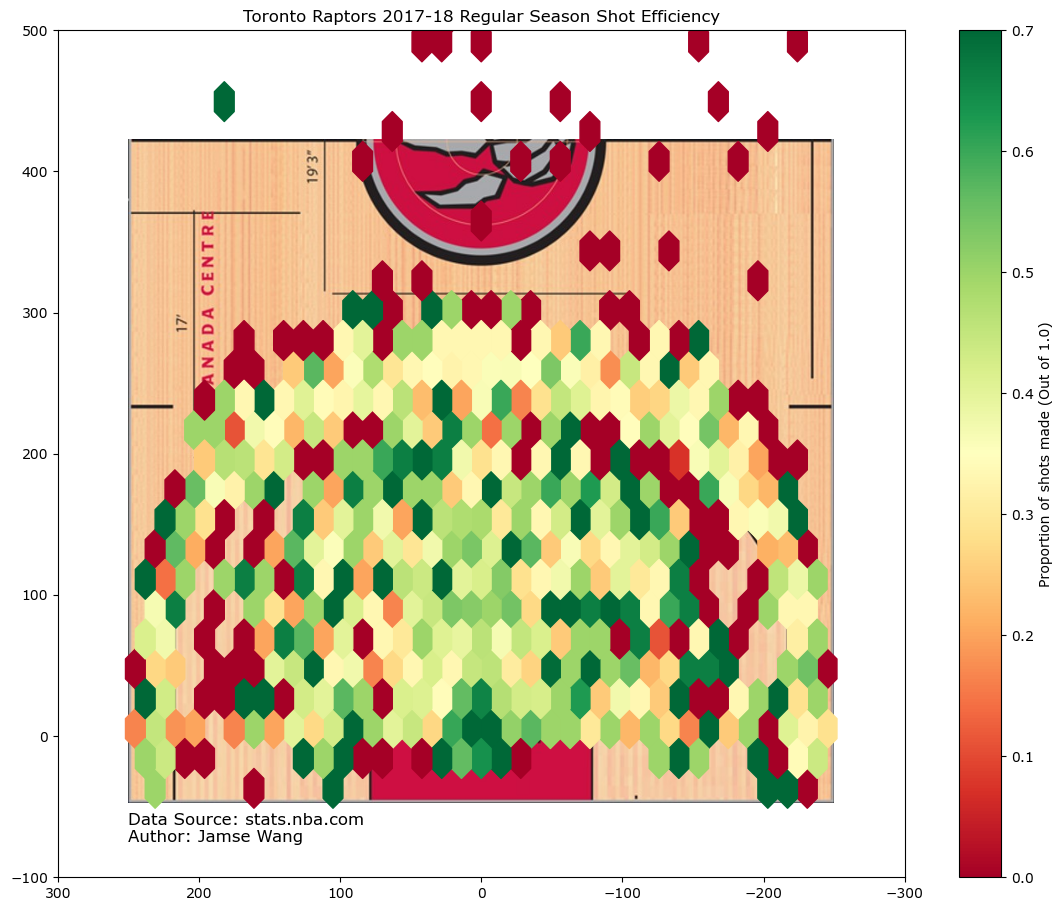

Which player would you like to plot? type name without spelling mistakes, 000 to go back to team selection
Pascal Siakam


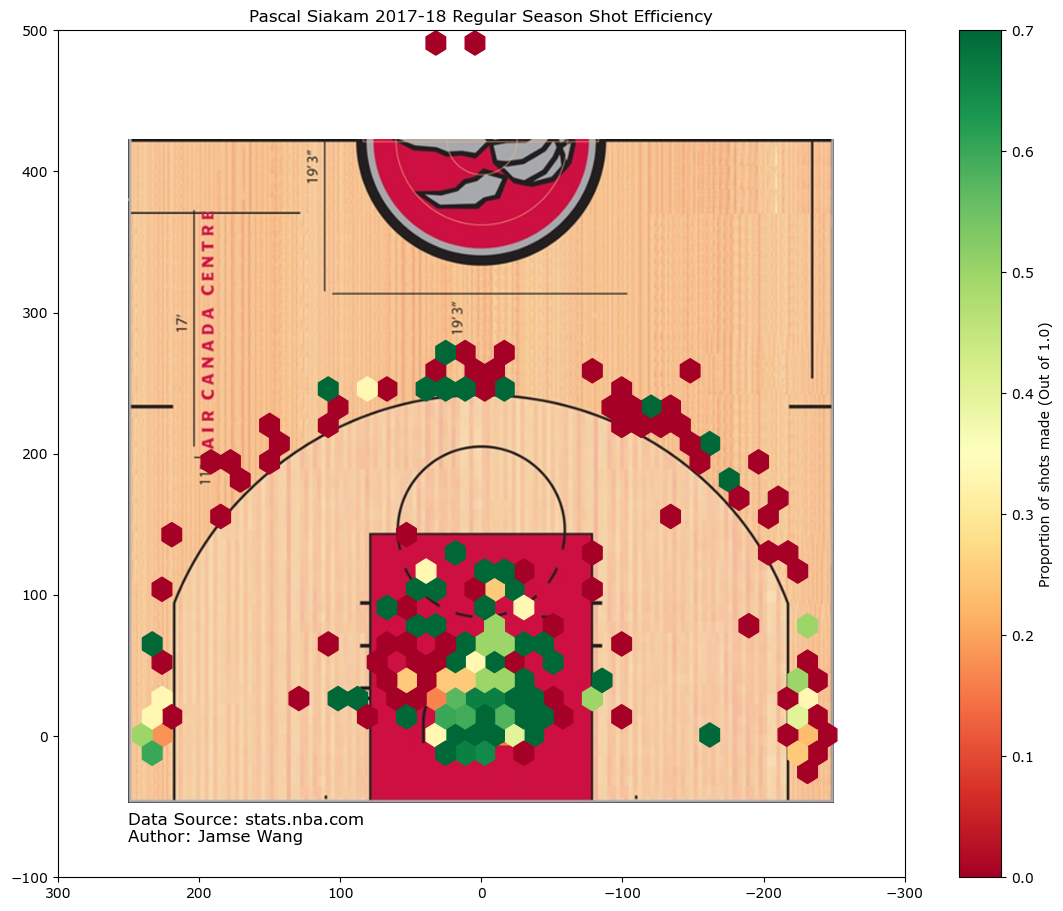

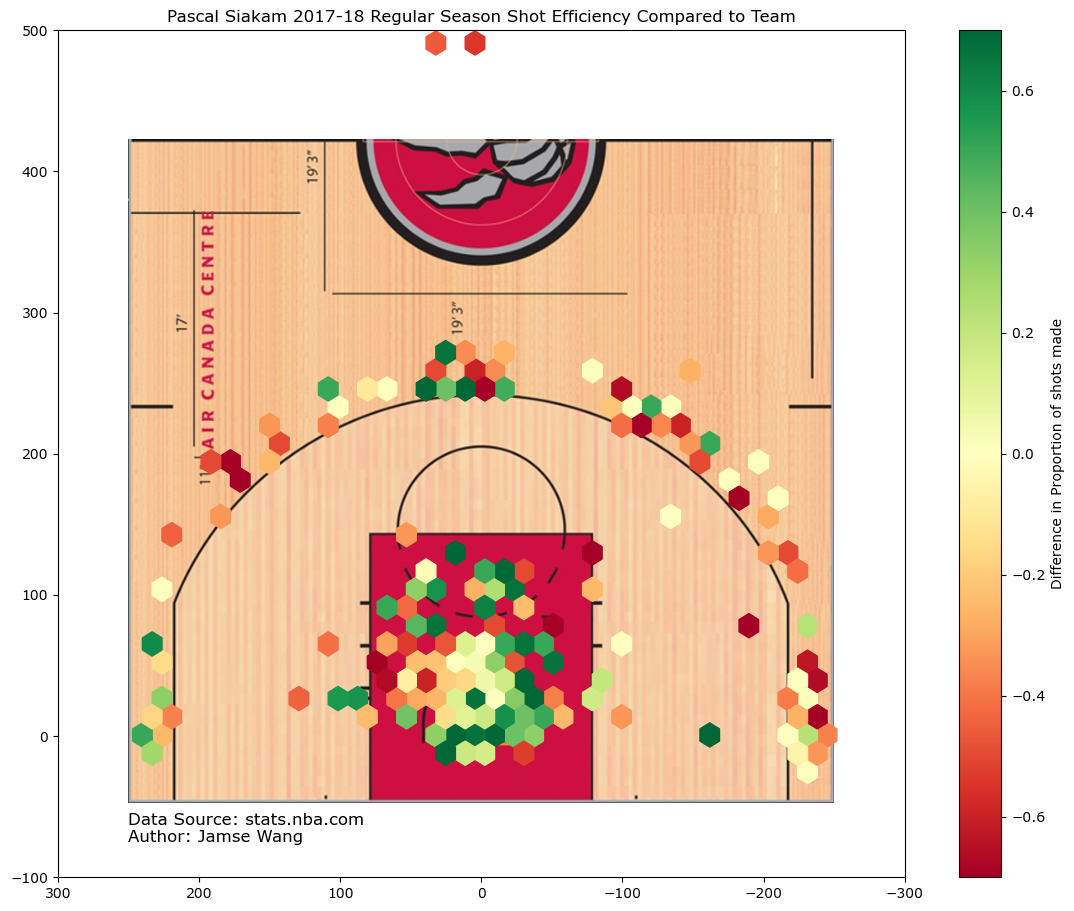

Which player would you like to plot? type name without spelling mistakes, 000 to go back to team selection
Fred VanVleet


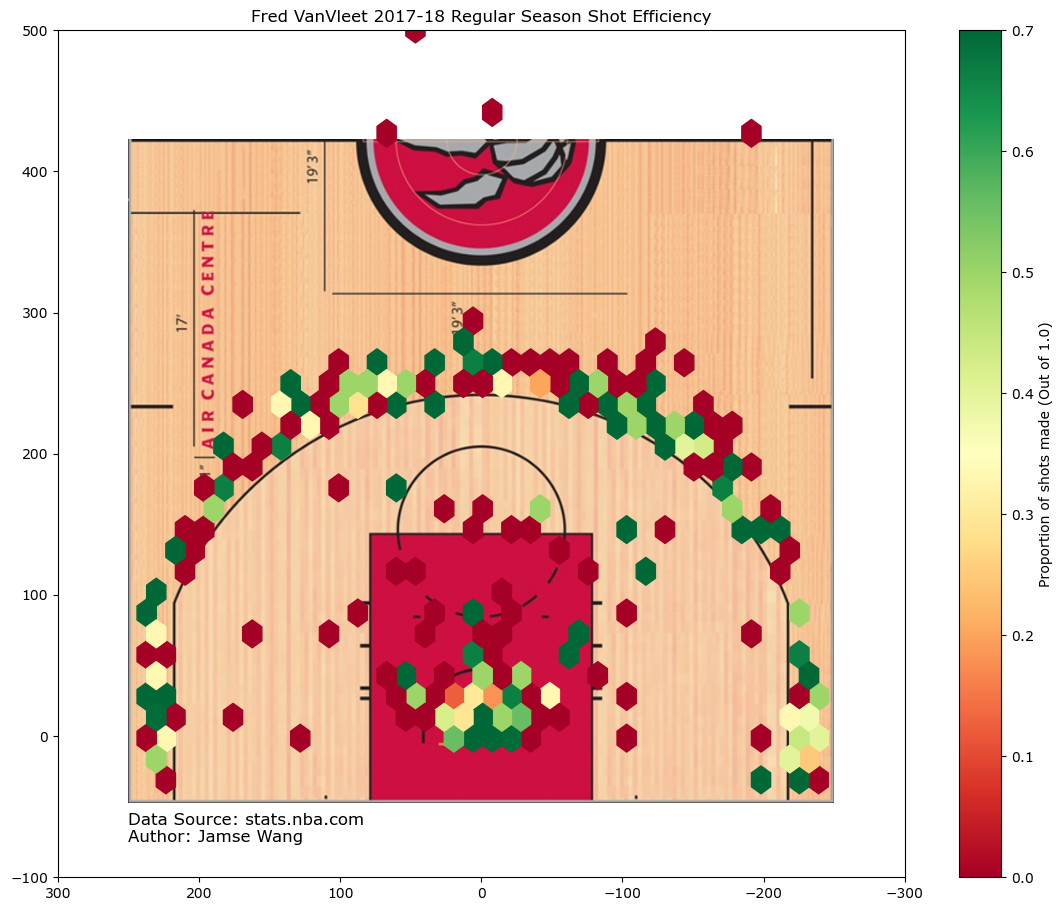

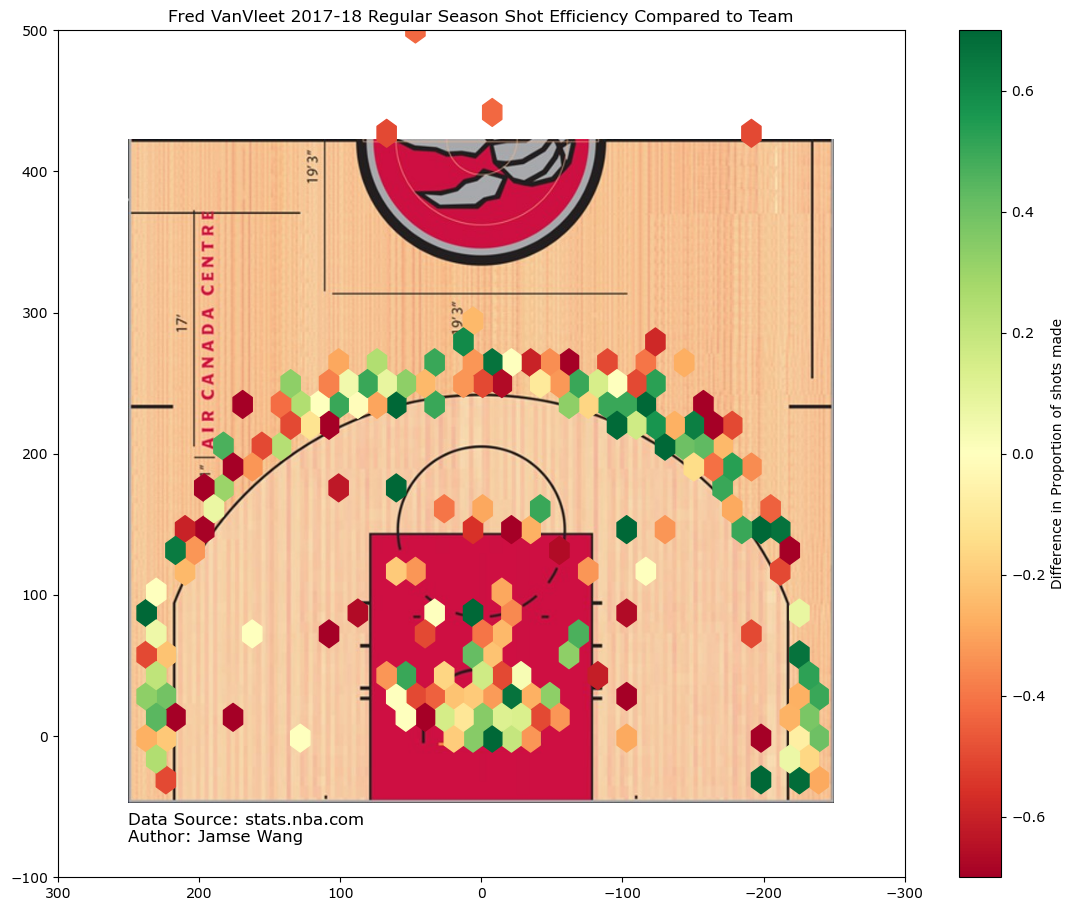

Which player would you like to plot? type name without spelling mistakes, 000 to go back to team selection
000
Team List
Atlanta Hawks                               1610612737
Boston Celtics                              1610612738
Cleveland Cavaliers                         1610612739
New Orleans Pelicans                        1610612740
Chicago Bulls                               1610612741
Dallas Mavericks                            1610612742
Denver Nuggets                              1610612743
Golden State Warriors                       1610612744
Houston Rockets                             1610612745
Los Angeles Clippers                        1610612746
Los Angeles Lakers                          1610612747
Miami Heat                                  1610612748
Milwaukee Bucks                             1610612749
Minnesota Timberwolves                      1610612750
Brooklyn Nets                               1610612751
New York Knicks                             1610612752

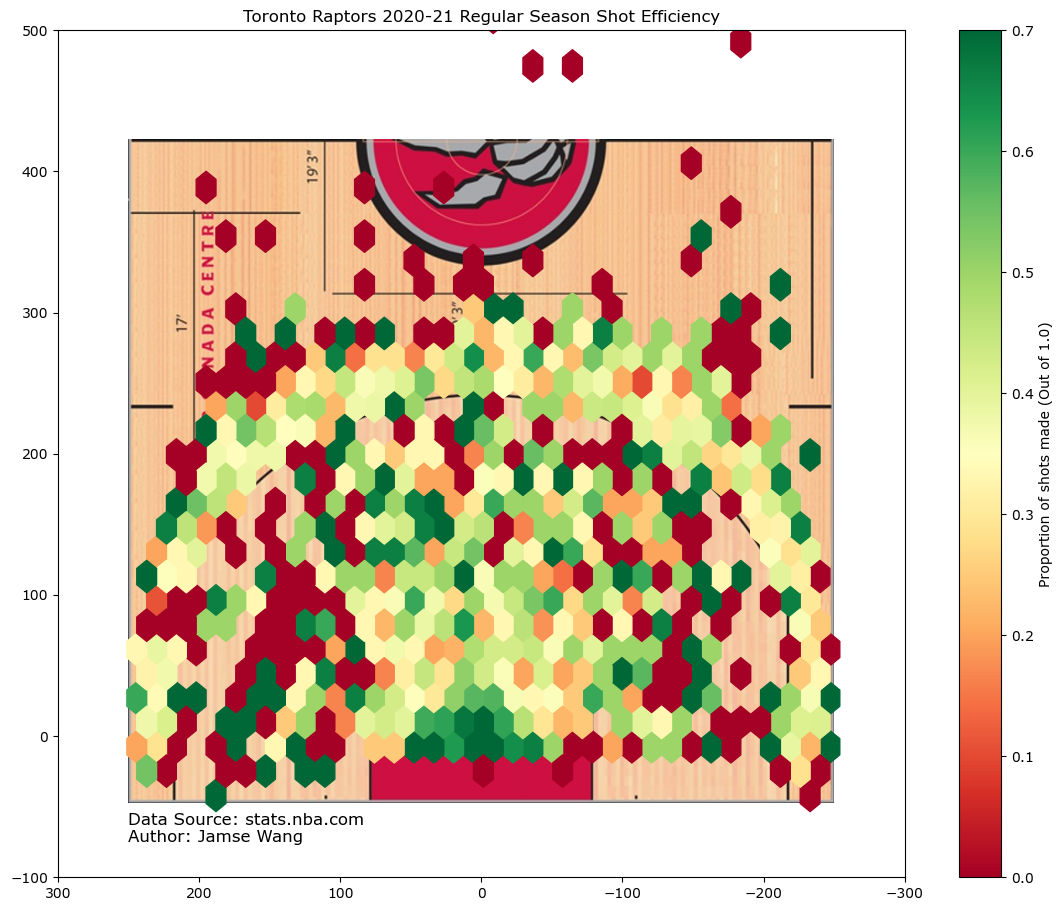

Which player would you like to plot? type name without spelling mistakes, 000 to go back to team selection
Pascal Siakam


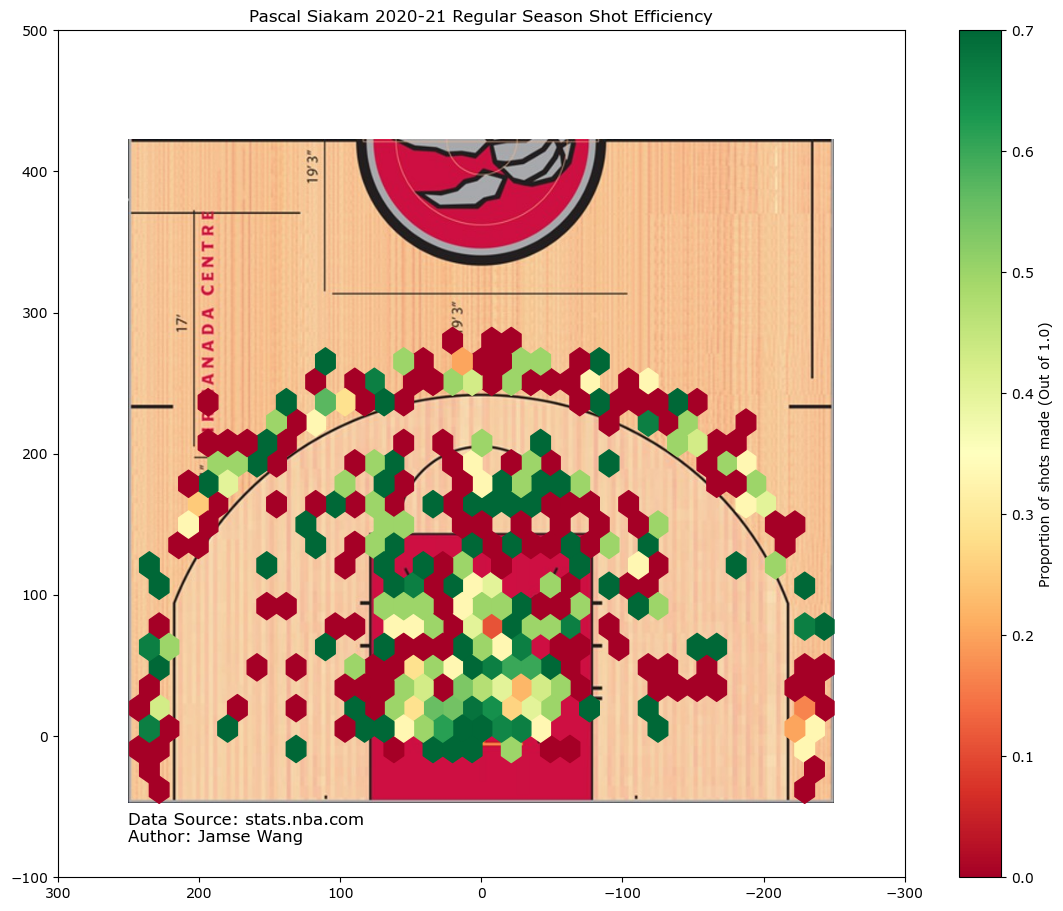

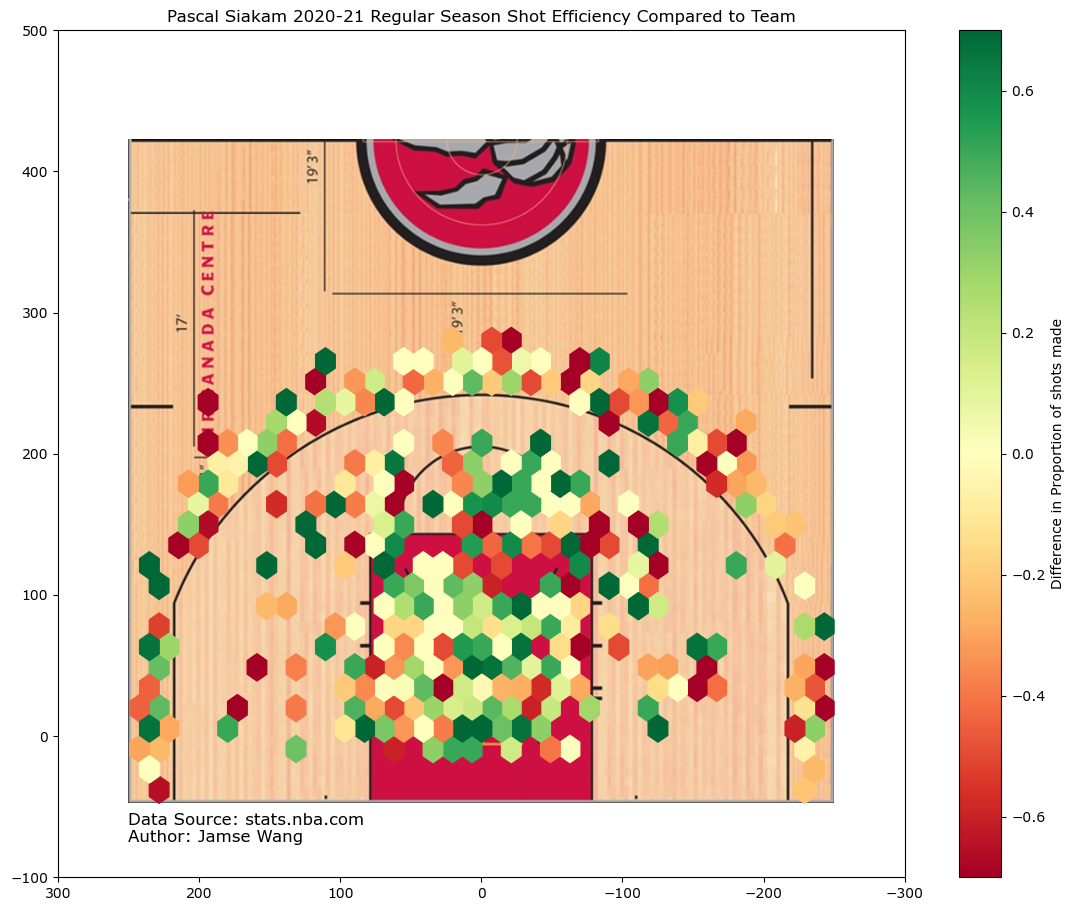

Which player would you like to plot? type name without spelling mistakes, 000 to go back to team selection
Fred VanVleet


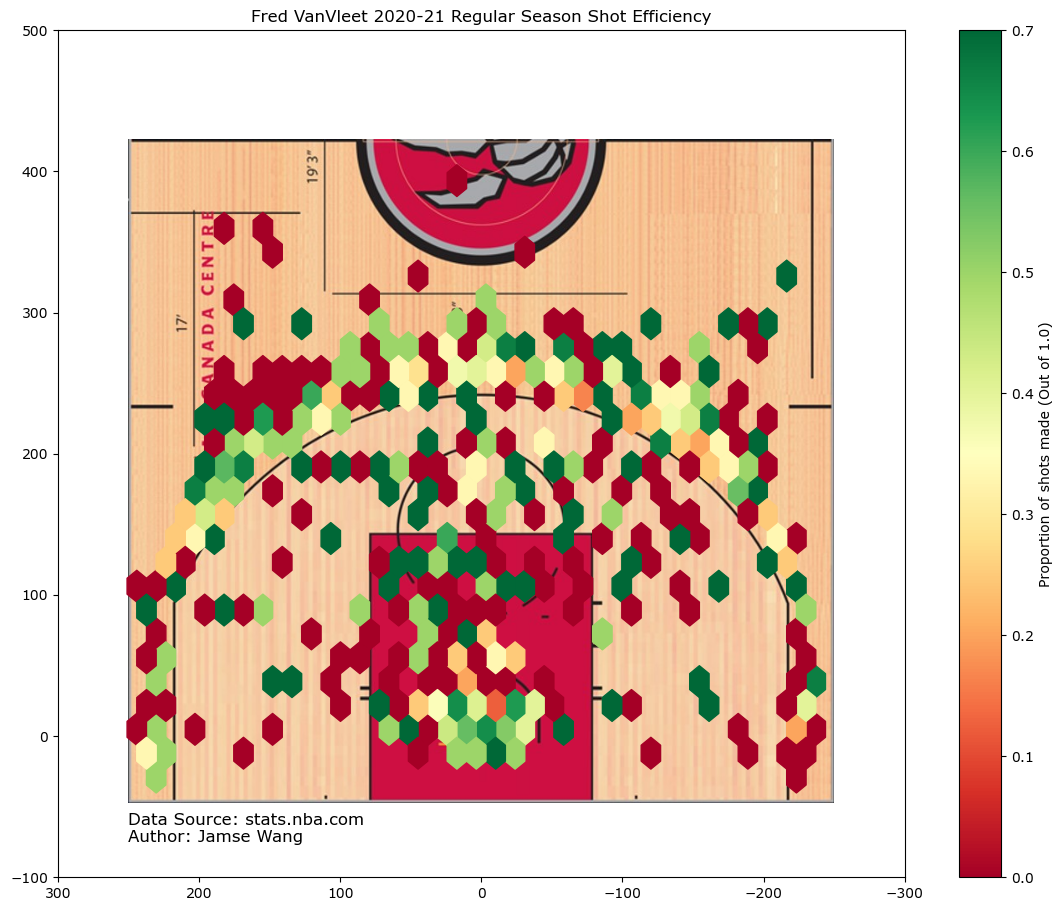

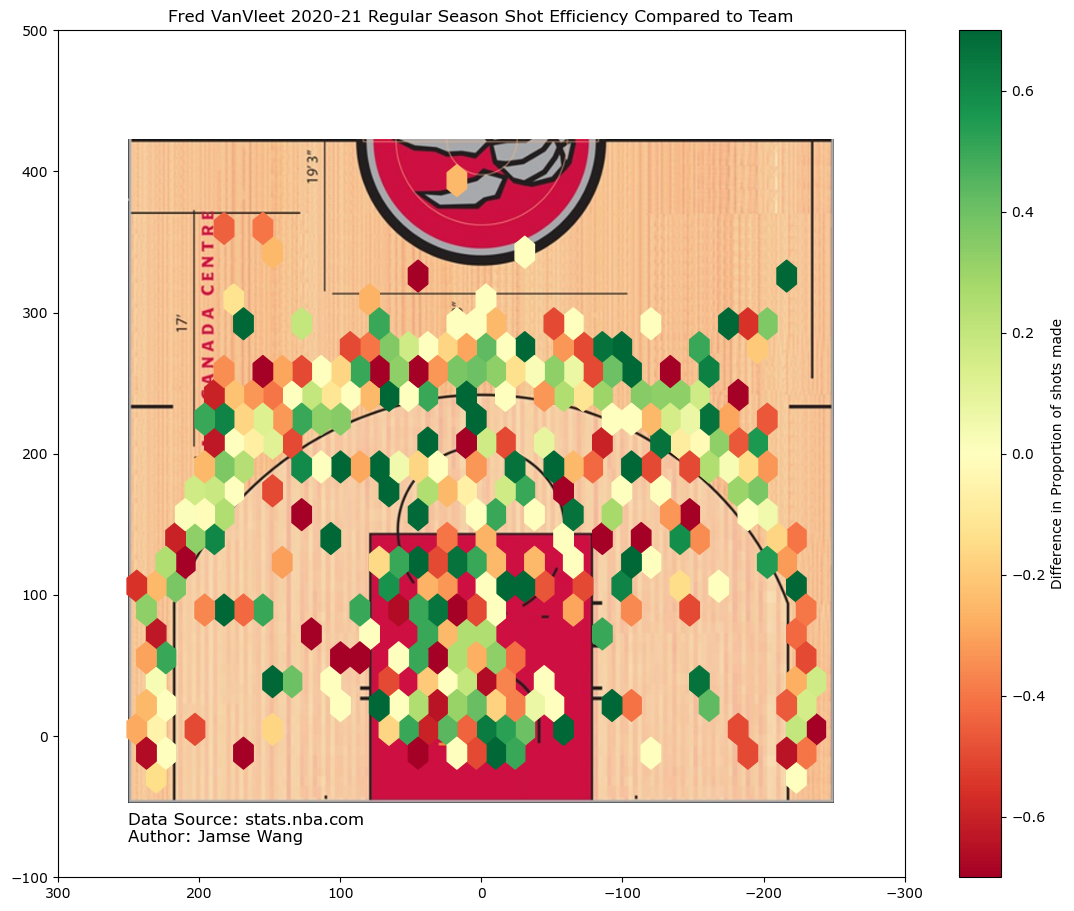

Which player would you like to plot? type name without spelling mistakes, 000 to go back to team selection


In [ ]:
main__()